# Mercedes-Benz Greener Manufacturing

The **Mercedes-Benz Greener Manufacturing** dataset is designed to predict the **time a car takes to pass through a testing process**, based on various anonymized features related to its manufacturing configuration.

This dataset was used in a Kaggle competition where the goal was to **optimize production efficiency** by reducing testing time, which is a critical step in Mercedes-Benz’s quality assurance process.

---

### Files Included

- `train.csv`  
  Contains the training data including the **target variable** `y`.  
  **Shape**: `(4209, 378)`

---

### Target Variable

- **`y`**:  
  Continuous real-valued variable.  
  Represents the **time (in seconds)** required for a car to pass testing.

---

### Feature Overview

- All features are **anonymous** and labeled as:  
  `X0`, `X1`, ..., `X385`
  
- Some features are **categorical** (e.g., `X0`, `X1`, `X2`), while others are **numerical**.

- **`ID`**:  
  Unique identifier for each row. Not a feature for modeling.

---



In [75]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge

**Step-1:** Import the dataset

In [76]:
df = pd.read_csv("/kaggle/input/mercedes-benz-greener-manufacturing/train.csv.zip")
print(df.shape)
df.head()

(4209, 378)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [77]:
X = df.drop('y', axis=1)
y = df['y']

**Step-2:** Clean and standardise data entries for consistency

In [78]:
#Strip leading/trailing whitespace from string columns
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype(str).str.strip()  # convert to string first to avoid errors

#  Convert text columns to lowercase for consistency
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].str.lower()

#  Replace common inconsistent entries (example)
# You can customize this based on your dataset
replace_dict = {
    'na': None,
    'n/a': None,
    'none': None,
    '?': None
}
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].replace(replace_dict)

# Remove duplicate rows (if necessary)
X = X.drop_duplicates()

# 5️Optional: Reset index after dropping duplicates
X = X.reset_index(drop=True)


**Step-3:** Handling the Null values in the dataset

In [79]:
X.isnull().sum()

ID      0
X0      0
X1      0
X2      0
X3      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 377, dtype: int64

In [80]:
#Drop the null values if you have more than 30% of Null

X.dropna(axis=1, thresh=0.7*len(X), inplace=True)

#Fill the null values
# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])


In [81]:
X.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,k,v,at,a,d,u,j,o,0,...,0,0,1,0,0,0,0,0,0,0
1,6,k,t,av,e,d,y,l,o,0,...,1,0,0,0,0,0,0,0,0,0
2,7,az,w,n,c,d,x,j,x,0,...,0,0,0,0,0,0,1,0,0,0
3,9,az,t,n,f,d,x,l,e,0,...,0,0,0,0,0,0,0,0,0,0
4,13,az,v,n,f,d,h,d,n,0,...,0,0,0,0,0,0,0,0,0,0


**Step-4:** Convert columns to appropriate types (i.e object --> category)

In [82]:
print(X.dtypes)

ID       int64
X0      object
X1      object
X2      object
X3      object
         ...  
X380     int64
X382     int64
X383     int64
X384     int64
X385     int64
Length: 377, dtype: object


In [83]:
# Convert 'object' columns with few unique values to 'category'
for col in X.select_dtypes(include='object').columns:
    if X[col].nunique() < 20:  # adjust threshold based on domain knowledge
        X[col] = X[col].astype('category')

# Fix numeric columns stored as strings (if any)
for col in X.select_dtypes(include='object').columns:
    try:
        X[col] = pd.to_numeric(X[col])
    except ValueError:
        pass  # Keep original if truly non-numeric


**Step-5:** Outlier Detection and Treatment

In [84]:
# Identify numerical columns only
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Outlier treatment using IQR method
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Print number of outliers
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

    # Optional: Remove outliers
    # X = X[(X[col] >= lower_bound) & (X[col] <= upper_bound)]

    # Optional: Cap outliers instead of removing
    # X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)


ID: 0 outliers
X10: 56 outliers
X11: 0 outliers
X12: 316 outliers
X13: 244 outliers
X14: 0 outliers
X15: 2 outliers
X16: 11 outliers
X17: 32 outliers
X18: 33 outliers
X19: 419 outliers
X20: 601 outliers
X21: 11 outliers
X22: 366 outliers
X23: 87 outliers
X24: 8 outliers
X26: 21 outliers
X27: 0 outliers
X28: 137 outliers
X29: 181 outliers
X30: 19 outliers
X31: 978 outliers
X32: 47 outliers
X33: 1 outliers
X34: 23 outliers
X35: 978 outliers
X36: 19 outliers
X37: 978 outliers
X38: 140 outliers
X39: 1 outliers
X40: 3 outliers
X41: 48 outliers
X42: 1 outliers
X43: 304 outliers
X44: 48 outliers
X45: 0 outliers
X46: 0 outliers
X47: 54 outliers
X48: 94 outliers
X49: 514 outliers
X50: 901 outliers
X51: 0 outliers
X52: 178 outliers
X53: 29 outliers
X54: 183 outliers
X55: 22 outliers
X56: 89 outliers
X57: 56 outliers
X58: 0 outliers
X59: 3 outliers
X60: 6 outliers
X61: 194 outliers
X62: 25 outliers
X63: 48 outliers
X64: 0 outliers
X65: 9 outliers
X66: 114 outliers
X67: 8 outliers
X68: 309 outlier

**Step-6:** Encode the categorical variables

In [85]:
# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply One-Hot Encoding to all categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Now X_encoded is ready for feature engineering or modeling


In [86]:
X = X_encoded.copy()

**Scaling the Features**

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
# 1. Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 3. Predictions
y_tr_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# 4. Evaluate
train_mse = mean_squared_error(y_train, y_tr_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_tr_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training MSE: {train_mse:.4f}, R2: {train_r2:.4f}")
print(f"Validation MSE: {val_mse:.4f}, R2: {val_r2:.4f}")

# 5. If you want predictions on test set (same as validation set here)
y_test_pred = y_val_pred  # or: lr_model.predict(X_val)


Training MSE: 60.9731, R2: 0.6236
Validation MSE: 71.0440, R2: 0.5436


**Apply Constant Feature**

In [89]:
constant_feature = [col for col in X.columns if X[col].nunique == 1]
print(constant_feature)

[]


**Quasi Constant Feature**

In [90]:
quasi_constant_feature = []
threshold = 0.99

for col in X.columns:
    freq = X[col].value_counts(normalize=True).iloc[0]
    if freq >= threshold:
        quasi_constant_feature.append(col)

print("quasi_constant_feature: ", quasi_constant_feature)

X = X.drop(columns=quasi_constant_feature, axis=1)

quasi_constant_feature:  ['X11', 'X15', 'X16', 'X17', 'X18', 'X21', 'X24', 'X26', 'X30', 'X33', 'X34', 'X36', 'X39', 'X40', 'X42', 'X53', 'X55', 'X59', 'X60', 'X62', 'X65', 'X67', 'X74', 'X78', 'X83', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X97', 'X99', 'X102', 'X104', 'X105', 'X107', 'X110', 'X112', 'X122', 'X123', 'X124', 'X125', 'X145', 'X153', 'X160', 'X165', 'X167', 'X169', 'X172', 'X173', 'X183', 'X184', 'X190', 'X192', 'X199', 'X200', 'X204', 'X205', 'X207', 'X210', 'X212', 'X213', 'X214', 'X216', 'X217', 'X221', 'X227', 'X230', 'X233', 'X235', 'X236', 'X237', 'X239', 'X240', 'X242', 'X243', 'X245', 'X248', 'X249', 'X252', 'X253', 'X254', 'X257', 'X258', 'X259', 'X260', 'X262', 'X266', 'X267', 'X268', 'X269', 'X270', 'X271', 'X274', 'X277', 'X278', 'X280', 'X281', 'X282', 'X288', 'X289', 'X290', 'X292', 'X293', 'X295', 'X296', 'X297', 'X298', 'X299', 'X307', 'X308', 'X309', 'X310', 'X312', 'X317', 'X318', 'X319', 'X320', 'X323', 'X325', 'X330', 'X3

**Duplicate Features**

In [91]:
train_T = X.T
duplicate_features = train_T[train_T.duplicated()].index.tolist()
print("Duplicate Features: ", duplicate_features)

X = X.drop(columns=duplicate_features, axis=1)

Duplicate Features:  ['X35', 'X37', 'X76', 'X84', 'X113', 'X119', 'X134', 'X146', 'X147', 'X222', 'X226', 'X232', 'X244', 'X247', 'X279', 'X302', 'X324', 'X326', 'X360', 'X2_ai', 'X2_aq', 'X2_as', 'X2_f', 'X2_n', 'X2_s']


**Correlation**

In [92]:
corr_matrix = X.corr()
corr_threshold = 0.98
corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j] > corr_threshold):
            corr_pairs.add(corr_matrix.columns[i])
print("Correlation Features: ", corr_pairs)

X = X.drop(columns=corr_pairs, axis=1)

Correlation Features:  {'X250', 'X2_m', 'X140', 'X264', 'X2_ay', 'X198', 'X137', 'X348', 'X54', 'X368', 'X129', 'X371', 'X0_az', 'X363', 'X263', 'X215', 'X352'}


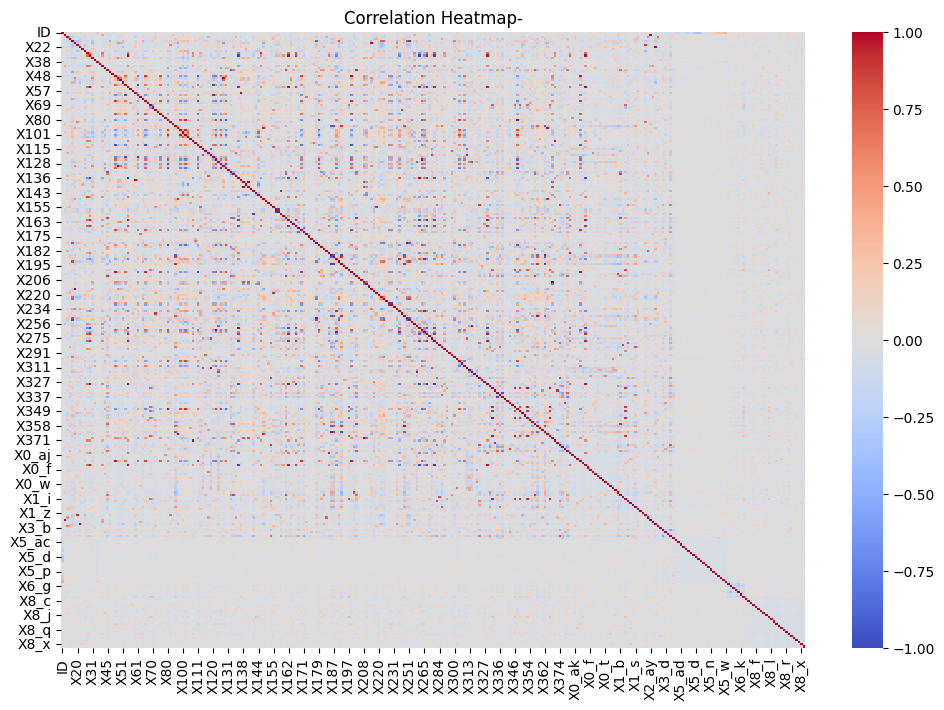

In [93]:
#Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap-")
plt.show()

In [94]:
mi_scores = mutual_info_regression(X, y, discrete_features=False)
mi_df = pd.Series(mi_scores, index=X.columns)
mi_df = mi_df.sort_values(ascending=False)


low_importance = mi_df[mi_df < 0.01].index.tolist()

print(low_importance)

X = X.drop(columns=low_importance,axis=1)

['X6_j', 'ID', 'X154', 'X349', 'X336', 'X327', 'X211', 'X135', 'X181', 'X23', 'X0_s', 'X103', 'X1_v', 'X117', 'X8_n', 'X175', 'X45', 'X0_al', 'X202', 'X63', 'X231', 'X283', 'X294', 'X8_f', 'X225', 'X109', 'X143', 'X1_b', 'X3_e', 'X8_e', 'X69', 'X161', 'X5_v', 'X219', 'X13', 'X8_k', 'X174', 'X321', 'X8_q', 'X151', 'X138', 'X8_w', 'X131', 'X57', 'X133', 'X163', 'X164', 'X44', 'X345', 'X5_ad', 'X177', 'X6_l', 'X38', 'X195', 'X6_h', 'X5_n', 'X359', 'X2_e', 'X1_r', 'X5_ag', 'X1_w', 'X1_l', 'X8_j', 'X206', 'X3_g', 'X287', 'X176', 'X373', 'X5_af', 'X5_k', 'X361', 'X196', 'X8_g', 'X5_r', 'X5_ae', 'X82', 'X1_o', 'X5_ah', 'X56', 'X8_v', 'X6_i', 'X1_z', 'X8_d', 'X8_b', 'X70', 'X2_ak', 'X73', 'X106', 'X322', 'X10', 'X8_r', 'X342', 'X5_m', 'X144', 'X5_p', 'X5_i', 'X8_m', 'X77', 'X41', 'X3_c', 'X6_k', 'X203', 'X8_x', 'X8_o', 'X340', 'X182', 'X8_h', 'X333', 'X329', 'X8_p', 'X305', 'X8_l', 'X8_t', 'X284', 'X8_u', 'X6_g', 'X8_c', 'X5_j', 'X3_b', 'X1_s', 'X291', 'X5_ab', 'X5_ac', 'X1_c', 'X5_c', 'X5_d',

In [95]:
from sklearn.feature_selection import f_regression
import pandas as pd

f_scores, p_values = f_regression(X, y)

anova_df = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
}, index=X.columns)

anova_df = anova_df.sort_values(by='F_Score', ascending=False)

insignificant_features = anova_df[anova_df['P_Value'] > 0.05].index.tolist()

print("Dropping features with weak linear relationship:", insignificant_features)

X = X.drop(columns=insignificant_features)

Dropping features with weak linear relationship: ['X375', 'X246', 'X220', 'X58', 'X358', 'X356', 'X0_d', 'X1_aa', 'X374', 'X186', 'X194', 'X49', 'X168', 'X114']


#### **log transformation to target**

In [96]:
import numpy as np
y_log = np.log1p(y)  # train on log-scale target


In [97]:
# 1. Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

### **Ridge Regression**

In [98]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)

# Evaluation
train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

In [99]:
print(f"Training MSE: {train_mse_ridge:.4f}, R2: {train_r2_ridge:.4f}")
print(f"Validation MSE: {val_mse_ridge:.4f}, R2: {val_r2_ridge:.4f}")

Training MSE: 0.0052, R2: 0.6408
Validation MSE: 0.0053, R2: 0.6306


### **Lasso Regression**

In [100]:
lasso_model = Lasso(alpha=0.1)  # Smaller alpha for better performance
lasso_model.fit(X_train, y_train)

y_train_pred_lasso = lasso_model.predict(X_train)
y_val_pred_lasso = lasso_model.predict(X_val)

# Evaluation
train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
val_mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
val_r2_lasso = r2_score(y_val, y_val_pred_lasso)

print(f"Training MSE: {train_mse_lasso:.4f}, R2: {train_r2_lasso:.4f}")
print(f"Validation MSE: {val_mse_lasso:.4f}, R2: {val_r2_lasso:.4f}")

Training MSE: 0.0145, R2: 0.0000
Validation MSE: 0.0144, R2: -0.0000


### **ElasticNet**

In [101]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)

y_val_pred_elastic = elastic_model.predict(X_val)
print("ElasticNet R2:", r2_score(y_val, y_val_pred_elastic))


ElasticNet R2: -3.416089018748458e-05



* ElasticNet R² (0.36) is significantly worse than all others.
* That means the current balance of L1/L2 (l1_ratio=0.5, alpha=1.0) is not suitable for your data.
* It likely over-penalized useful features.


*  **Ridge Regression** clearly outperformed both Lasso and baseline Linear Regression:

    - Lowest **Validation MSE** → Best generalization.
        
    - Highest** Validation R**² → Explains more variance on unseen data.

* **Lasso slightly improved Validation R² over the baseline**, but:

    - It sacrificed too much fit on the training set.

    - Likely zeroed out some useful features (since Lasso can eliminate coefficients).

#### **Tune Alpha with Cross Validation**

In [102]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge_cv.fit(X_train, y_train)

print(f"Best alpha from CV: {ridge_cv.alpha_}")

y_train_pred = ridge_cv.predict(X_train)
y_val_pred = ridge_cv.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}, R2: {val_r2:.4f}")


Best alpha from CV: 10.0
Validation MSE: 0.0054, R2: 0.6290


In [103]:
print("Intercept (bias term):", ridge_cv.intercept_)


Intercept (bias term): 4.598955759261055


#### **Actual vs Predicted**

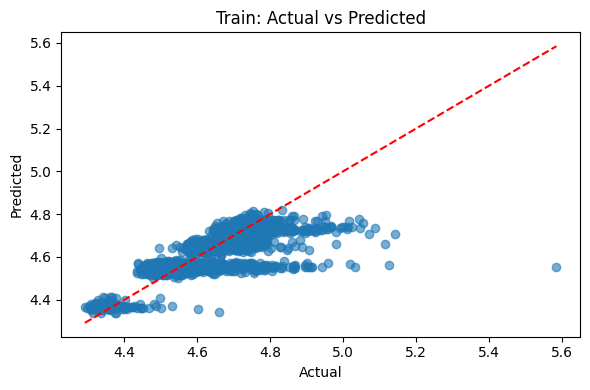

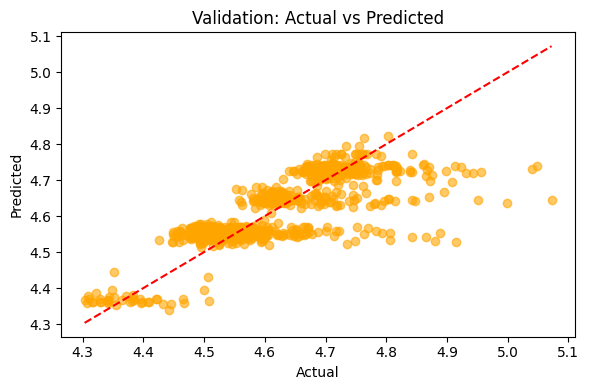

In [104]:
import matplotlib.pyplot as plt

# Train
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title("Train: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

# Validation
plt.figure(figsize=(6, 4))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Validation: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


#### Residual Plot

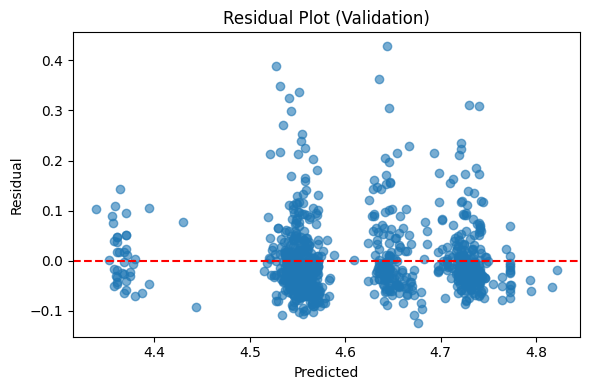

In [105]:
val_residuals = y_val - y_val_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred, val_residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residual Plot (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

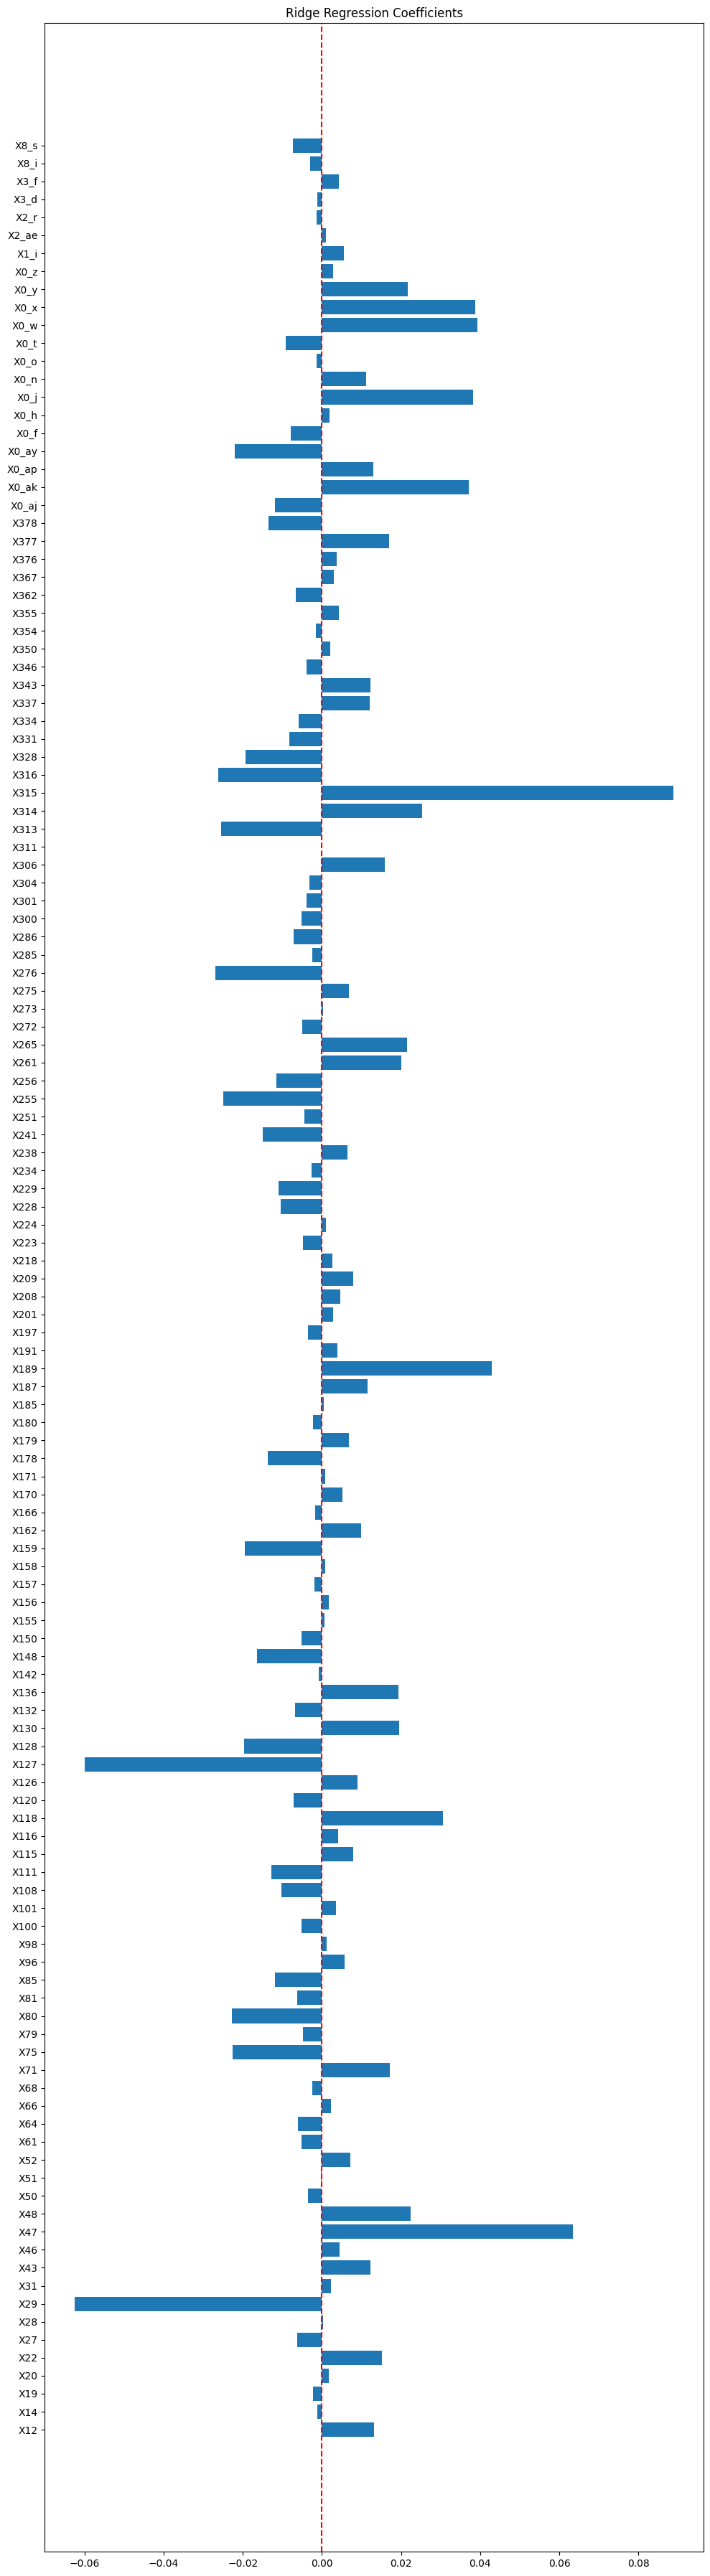

In [106]:
# Replace with your actual feature names if needed
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]
coefficients = ridge_cv.coef_

plt.figure(figsize=(10, 36))
plt.barh(feature_names, coefficients)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ridge Regression Coefficients")
plt.tight_layout()
plt.show()

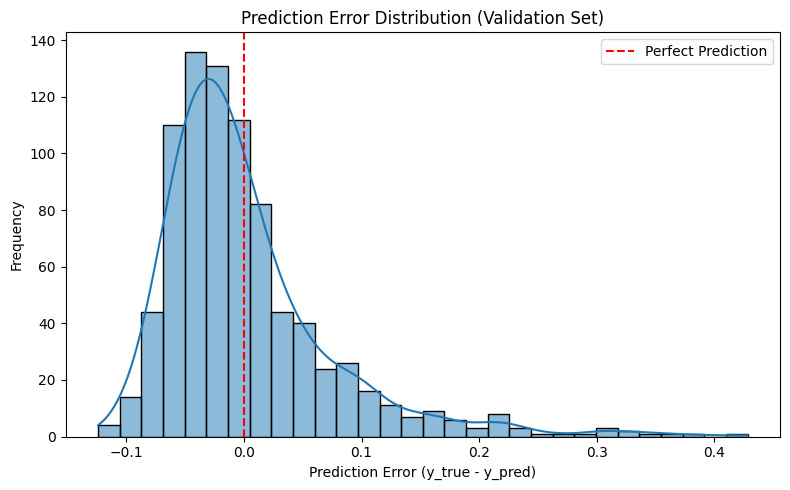

In [107]:
# Calculate errors (residuals) on validation set
errors = y_val - y_val_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--', label="Perfect Prediction")
plt.title("Prediction Error Distribution (Validation Set)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


#### **Without log transformation to your target**

In [108]:
# 1. Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge_cv.fit(X_train, y_train)

print(f"Best alpha from CV: {ridge_cv.alpha_}")

y_train_pred = ridge_cv.predict(X_train)
y_val_pred = ridge_cv.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}, R2: {val_r2:.4f}")


Best alpha from CV: 10.0
Validation MSE: 64.8157, R2: 0.5836


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Training Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Validation Metrics
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Training Metrics:")
print(f"MAE:  {train_mae:.4f}")
print(f"MSE:  {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²:   {train_r2:.4f}")

print("\nValidation Metrics:")
print(f"MAE:  {val_mae:.4f}")
print(f"MSE:  {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R²:   {val_r2:.4f}")


Training Metrics:
MAE:  5.2292
MSE:  69.0903
RMSE: 8.3121
R²:   0.5735

Validation Metrics:
MAE:  5.3788
MSE:  64.8157
RMSE: 8.0508
R²:   0.5836


In [111]:
print("Intercept (β₀):", ridge_cv.intercept_)

Intercept (β₀): 101.1895561644083


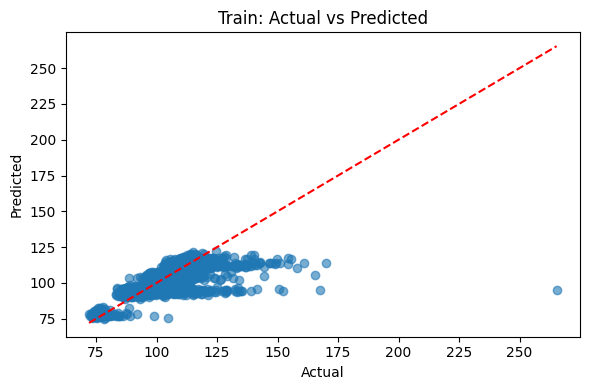

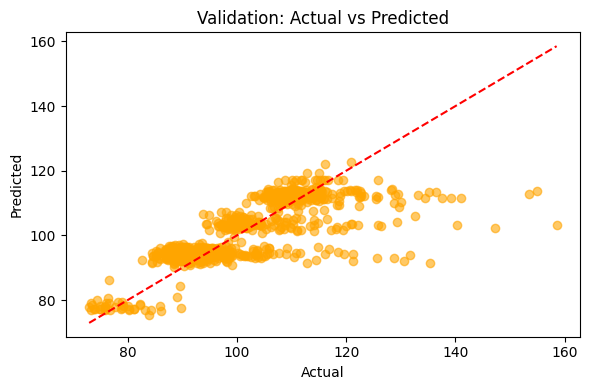

In [112]:
# Training set
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Train: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Validation set
plt.figure(figsize=(6, 4))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Validation: Actual vs Predicted")
plt.tight_layout()
plt.show()


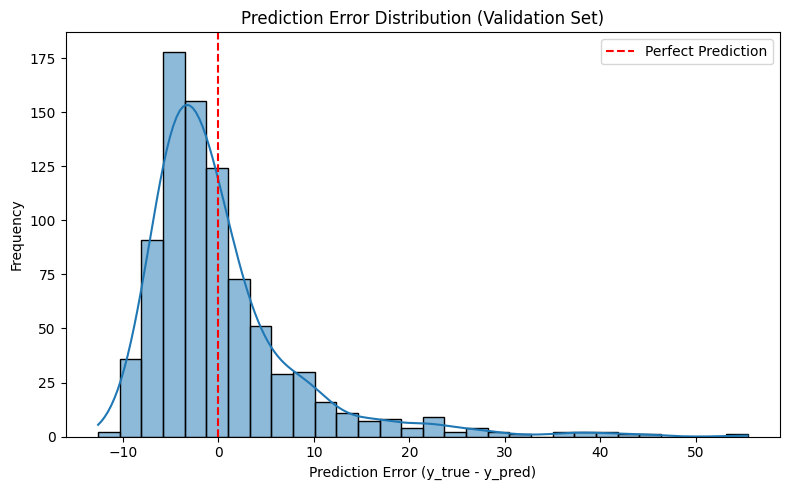

In [113]:
errors = y_val - y_val_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--', label="Perfect Prediction")
plt.title("Prediction Error Distribution (Validation Set)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


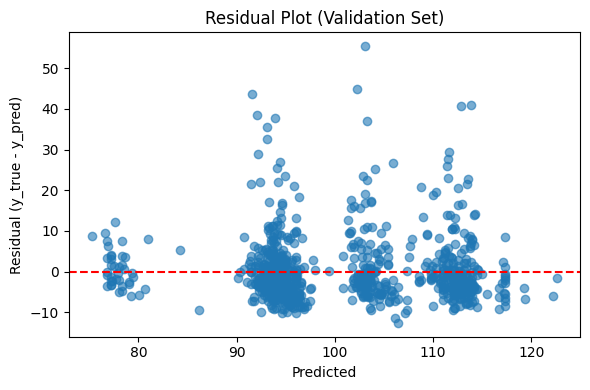

In [114]:
plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred, errors, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot (Validation Set)")
plt.tight_layout()
plt.show()


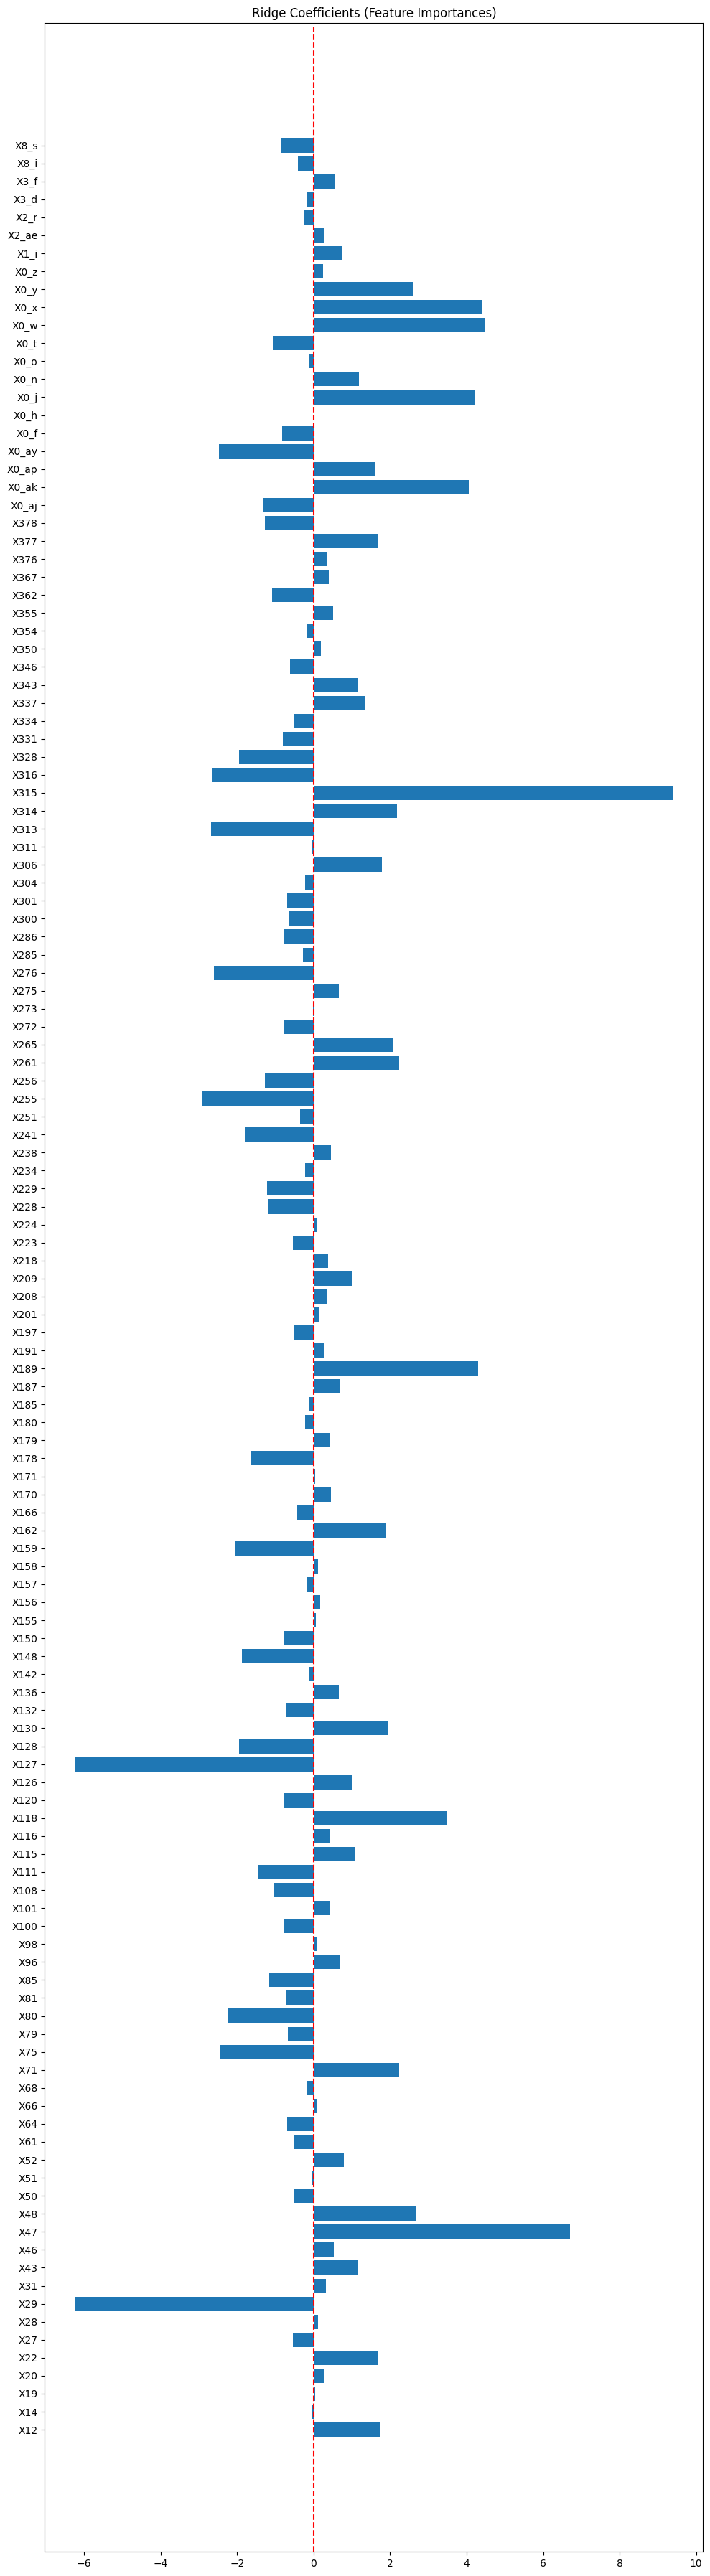

In [115]:
plt.figure(figsize=(10, 36))
plt.barh(X_train.columns, ridge_cv.coef_)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ridge Coefficients (Feature Importances)")
plt.tight_layout()
plt.show()
